Corrective moment:
$$ M_c = C_1 \alpha_x$$
Damping moment:
$$ M_d = C_2 \Omega_x$$
([1] p. 84)


Normal force:
$$ N = C_{N\alpha} \frac{\rho}{2} A_r V^2 \alpha $$
([1] p. 186)


In [1]:
rho = 1.225 # kg/m3, air density

from math import tan, atan2, cos, pi, sqrt

In [2]:
# reference area Ar (radius rr) is the area under the nosecone
# the formulas are from [1] p. 184

def nosecone(shape, length):
    """ shape: nosecone shape
        length: nosecone length
        returns (CP (to tip of nosecone), C_Nalpha)
    """
    CP = {"conical": 2/3,
          "ogive": 0.466,
          "paraboloidal": 1/2,
          "ellipsoidal": 1/3 } # [1] p. 189
    C_Nalpha = 2.0 # [1] p. 190
    return (CP[shape]*length, C_Nalpha)

def fin(N, span, root_chord, tip_chord, sweep_angle_deg, r_tube, rr):
    """ N: Number of fins
        span: span of a single fin
        sweep_angle_deg: sweep angle of the leading edge
        r_tube: tube radius where the fins are
        rr: reference radius
        returns (CP (to root leading edge), C_Nalpha)
    """
    sweep = tan(sweep_angle_deg / 180 * pi)*span # sweep back distance
    AR = 4*span/(root_chord + tip_chord)  # aspect ratio (this is actually wrong in [1])
    Gamma =  atan2(sweep + tip_chord/2 - root_chord/2, span)# sweep angle at half cord
    C_Nalpha = ( N * AR * (root_chord+tip_chord)/(2*rr) * span/rr) / (2 + sqrt(4 + (AR/cos(Gamma))**2))
    Tau = (span + r_tube) / r_tube
    C_NalphaB = (1 + 1/Tau)*C_Nalpha
    CP = sweep/3*(root_chord + 2*tip_chord)/(root_chord + tip_chord) + \
        1/6*(root_chord  + tip_chord - root_chord*tip_chord/(root_chord + tip_chord))
    return (CP, C_NalphaB)

rocket = [[nosecone('ogive', length=0.610), 0],
          [fin(N=3, span=0.115, root_chord=0.210, tip_chord=0.070, sweep_angle_deg=45, r_tube=0.158/2, rr=0.158/2), 2.450]]

print(rocket)

# fin cn_alpha should be 3.9004

def CP(rocket):
    cn = 0
    cm = 0
    for part, pos in rocket:
        part_cp, part_cn = part
        cn += part_cn
        cm += (part_cp + pos)*part_cn
    return (cm/cn, cn)


CP(rocket)

[[(0.28426, 2.0), 0], [(0.08583333333333332, 3.8337792465094425), 2.45]]


(1.7639243398003577, 5.833779246509442)

In [3]:
rr = 0.158/2
I_L = 7.422 # [kg*m2] longitudinal moment of inertia
Ar = rr**2*pi
rho = 1.225 # [kg/m3] air density
xcp, cn = CP(rocket)
xcm = 1.567
print('static stability: {}'.format((xcp-xcm)/(rr*2)))
C1 = lambda V: rho/2*V**2 * Ar * cn*(xcp-xcm)
C2A = lambda V: rho/2*V*Ar* sum([(part[0][0]+part[1]-xcm)**2 * part[0][1] for part in rocket])
C2P = 0 # todo propulsive damping
damping_ratio = C2A(1)/(2*sqrt(C1(1)*I_L)) # damping ratio does not depend on airspeed
print('damping ratio: {} (0.05-0.3)'.format(damping_ratio)) # according to [1] sec. 5.2.4

static stability: 1.2463565810149224
damping ratio: 0.12927654041232353 (0.05-0.3)


In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
x1, y1 = [-1, 12], [1, 4]
x2, y2 = [1, 10], [3, 2]

def draw_nose(pos, l, r):
    plt.plot([pos, pos+l, pos+l, pos], [0, r, -r, 0])

def draw_body(pos, l, r):
    plt.plot([pos, pos+l, pos+l, pos, pos], [r, r, -r, -r, r])

def draw_fin(pos, r, root, sweep, tip, span):
    plt.plot([pos, pos+sweep, pos+sweep+tip, pos+root, pos], [r, r+span, r+span, r, r])

def draw(rocket):
    for c in rocket['comp']:
        p = c[2]
        if c[0] == 'fin':
            sweep = tan(p['sweep_angle_deg'] / 180 * pi)*p['span']
            draw_fin(c[1], p['r_tube'], p['root_chord'], sweep, p['tip_chord'], p['span'])
        if c[0] == 'nosecone':
            draw_nose(c[1], p['length'], rocket['rr'])
        if c[0] == 'body':
            draw_body(c[1], p['l'], p['r'])
    #plt.plot(2,0, marker='o')
    plt.axis('equal')
    plt.show()

In [5]:
def stability(rocket):
    Ar = rocket['rr']**2*pi
    Dr = rocket['rr']*2
    fn = {'fin': fin, 'nosecone': nosecone, 'body': lambda r, l: [0, 0]}
    comp = [[fn[c[0]](**c[2]), c[1]] for c in rocket['comp']]
    xcp, cn = CP(comp)
    print('static stability: {:.2f} ... {:.2f}'.format((xcp-rocket['xcm'][0])/Dr, (xcp-rocket['xcm'][1])/Dr))
    print('lift {} at 100m/s'.format(rho/2*(100)**2 * Ar * cn))
    C1 = lambda V: rho/2*V**2 * Ar * cn*(xcp-rocket['xcm'][0])
    #print(cn, xcp-rocket['xcm'][0])
    #print([((part[0][0]+part[1]-rocket['xcm'][0])**2,part[0][1]) for part in comp])
    C2A = lambda V: rho/2*V*Ar* sum([(part[0][0]+part[1]-rocket['xcm'][0])**2 * part[0][1] for part in comp])
    print('C1 {} C2 {}'.format(C1(100), C2A(100)))
    C2P = 0 # todo propulsive damping
    damping_ratio = C2A(1)/(2*sqrt(C1(1)*rocket['I_L'])) # damping ratio does not depend on airspeed
    print('damping ratio: {} (0.05-0.3)'.format(damping_ratio)) # according to [1] sec. 5.2.4
    

static stability: 1.25 ... 1.67
lift 700.5838787260128 at 100m/s
C1 137.96201779289396 C2 8.273513137350914
damping ratio: 0.12927654041232353 (0.05-0.3)
static stability: 0.99 ... 1.79
lift 700.5838787260128 at 100m/s
C1 109.93866264385342 C2 8.174352865176214
damping ratio: 0.11007771158074363 (0.05-0.3)
static stability: 0.98 ... 1.78
lift 2117.3045935478485 at 100m/s
C1 329.1917049870843 C2 15.681344633014495
damping ratio: 0.12203378848982203 (0.05-0.3)


<IPython.core.display.Javascript object>


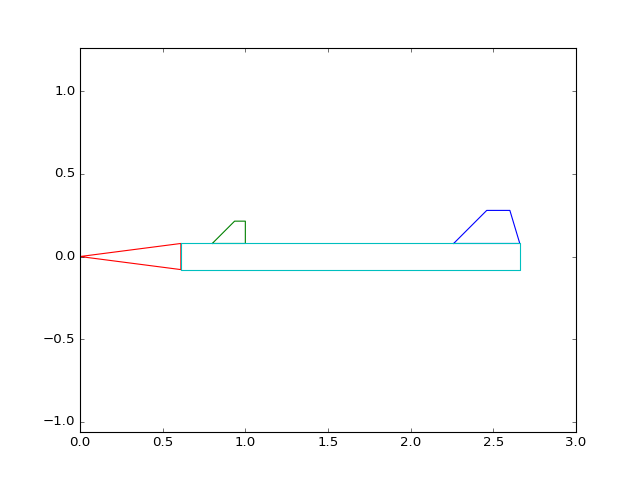

In [6]:
roro_test_launch = {
'rr': 0.158/2, 'xcm': [1.567, 1.5], 'I_L': 7.422,
'comp': [
    ['fin', 2.450, {'N': 3, 'span': 0.115, 'root_chord': 0.210, 'tip_chord': 0.070, 'sweep_angle_deg': 45, 'r_tube': 0.158/2, 'rr': 0.158/2}],
    ['nosecone', 0, {'shape': 'ogive', 'length': 0.610}]
]}


# M2400 Launch Mass
# Lift-off mass: 27.030kg, CG: 1607, Ix 77'757'150gmm2, Iy&Iz 12'540'000'000gmm2
# Mass after burnout: 23.340kg, GC: 1481, Ix 74'136'780gmm2, Iy&Iz 9'756'000'000gmm2
roro_comp = {
'rr': 0.158/2, 'xcm': [1.607, 1.481], 'I_L': 12.540,
'comp': [
    ['fin', 2.450, {'N': 3, 'span': 0.115, 'root_chord': 0.210, 'tip_chord': 0.070, 'sweep_angle_deg': 45, 'r_tube': 0.158/2, 'rr': 0.158/2}],
    ['nosecone', 0, {'shape': 'ogive', 'length': 0.610}],
    ['body',  0.610, {'r': 0.158/2, 'l': 2.050}]
]}

roro_stable = {
'rr': 0.158/2, 'xcm': [1.607, 1.481], 'I_L': 12.540,
'comp': [
    ['fin', 2.260, {'N': 3, 'span': 0.20, 'root_chord': 0.400, 'tip_chord': 0.140, 'sweep_angle_deg': 45, 'r_tube': 0.158/2, 'rr': 0.158/2}],
    #['fin', 2.450, {'N': 3, 'span': 0.115, 'root_chord': 0.210, 'tip_chord': 0.070, 'sweep_angle_deg': 45, 'r_tube': 0.158/2, 'rr': 0.158/2}],
    ['fin', 0.8, {'N': 3, 'span': 0.135, 'root_chord': 0.200, 'tip_chord': 0.065, 'sweep_angle_deg': 45, 'r_tube': 0.158/2, 'rr': 0.158/2}],
    ['nosecone', 0, {'shape': 'ogive', 'length': 0.610}],
    ['body',  0.610, {'r': 0.158/2, 'l': 2.050}]
]}

stability(roro_test_launch)
stability(roro_comp)
stability(roro_stable)
draw(roro_stable)

# References:
__[1] Topics in Advanced Model Rocketry__, Mandell, Paporaso, Bengen, ISBN: 0-262-02096-3